In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_rel,wilcoxon,ranksums,ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import AgglomerativeClustering
import sys
sys.path.append("../code")
from analysis_utils import *

In [66]:
sns.set_context('notebook',font_scale=1.5)

In [67]:
dfP = pd.read_table('../data/KMAC-DeepAccess-library_TFOverExpr-2.csv')
df = pd.read_table('../data/KMAC-DeepAccess-library.csv')

In [68]:
def rename_column(c):
    if 'dpn' in c:
        if '-' in c:
            splitc = c.split('-')
            return splitc[0]+'.'+splitc[2]+'-'+splitc[1]
        elif '.' in c:
            expt = c.split('i.')[1]
            digest = c.split('.')[0]
            return expt+'-'+digest
    else:
        return c
df.columns = [rename_column(c) for c in df.columns]
dfP.columns = [rename_column(c) for c in dfP.columns]

In [69]:
def normalize(df):
    expts = set([c.split('-')[0] for c in df.columns if 'dpn' in c])
    dpn_cols = list([c for c in df.columns if 'dpn' in c])
    norm =df.copy()
    for expt in expts:
        norm[expt+'-dpnii'] = norm[expt+'-dpnii']/(np.sum(norm[expt+'-dpnii'])/1000000)
        norm[expt+'-dpni'] = norm[expt+'-dpni']/(np.sum(norm[expt+'-dpni'])/1000000)
        norm[expt] = norm[expt+'-dpnii']/(norm[expt+'-dpni']+norm[expt+'-dpnii'])
    return norm

def normalizeP(df,rep):
    expts = set([c.split('-')[0] for c in df.columns if 'dpn' in c])
    dpn_cols = [c for c in df.columns if 'dpn' in c]
    norm =df.copy()
    #norm = norm[np.all(norm[dpn_cols] != 0,axis=1)]
    for expt in expts:
        norm[expt+'-dpnii'] = norm[expt+'-dpnii']/(np.sum(norm[expt+'-dpnii'])/1000000)
        norm[expt+'-dpni'] = norm[expt+'-dpni']/(np.sum(norm[expt+'-dpni'])/1000000)
        norm[expt+'_'+rep] = norm[expt+'-dpnii']/(norm[expt+'-dpni']+norm[expt+'-dpnii'])
    norep_expts = ['.'.join(expt.split('.')[:-1]) for expt in expts]
    return norm

In [70]:
norm = normalize(df)
norm_perturb = normalizeP(dfP,'Sept')

In [71]:
norm['total normalized reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
norm_perturb['total normalized reads'] = norm_perturb[[c for c in norm_perturb.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)

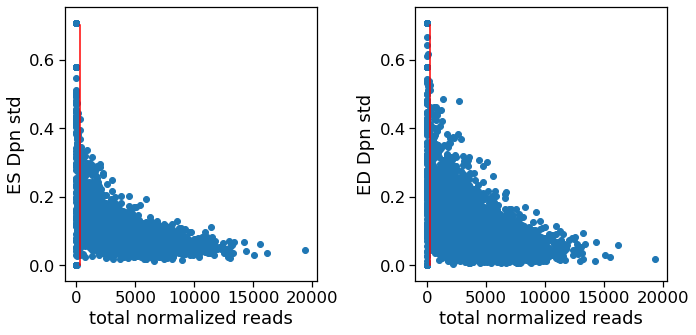

In [72]:
norm['ES Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'es' and 'dpn' not in c]].std(axis=1)
norm['ED Dpn std'] = norm[[c for c in norm.columns if c[:2] == 'ed' and 'dpn' not in c]].std(axis=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=norm)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
norm['total_reads'] = norm[[c for c in norm.columns if 'dpni' in c or 'dpnii' in c]].sum(axis=1)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=norm)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.show()

In [73]:
norm_perturb['FoxA2 STD'] = norm_perturb[[c for c in  norm_perturb.columns if 'foxa2' in c and 'dpn' not in c]].std(axis=1)
norm_perturb['T STD'] = norm_perturb[[c for c in  norm_perturb.columns if 'brachyury' in c and 'dpn' not in c]].std(axis=1)

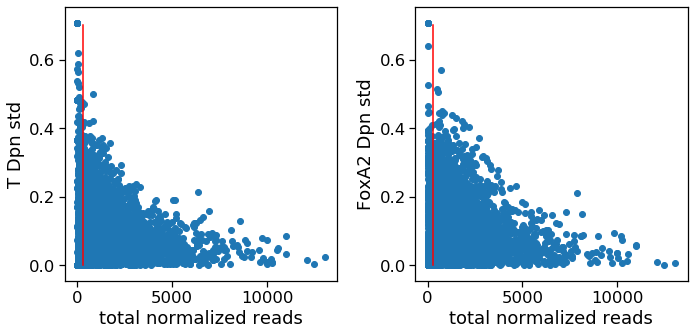

In [74]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='T STD',data=norm_perturb)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('T Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
plt.scatter(x='total normalized reads',y='FoxA2 STD',data=norm_perturb)
plt.plot([300,300],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('FoxA2 Dpn std')
plt.tight_layout()
plt.show()

In [75]:
norm = norm[norm['total normalized reads'] > 300]
# TODO edit so phrases without controls are not N/As
norm.dropna(inplace=True)
norm_perturb = norm_perturb[norm_perturb['total normalized reads'] > 300]
# TODO edit so phrases without controls are not N/As
norm_perturb.dropna(inplace=True)

In [76]:
len(norm)

5507

In [77]:
len(norm_perturb)

4908

In [78]:
replicates=[c for c in norm.columns if c[0] == 'e' and 'dpn' not in c and 'average' not in c]

In [79]:
norm_perturb = pd.merge(norm_perturb, norm[['seq']+replicates], on='seq')
norm_perturb['kmer'] = [get_kmer(d) for d  in norm_perturb['description']]
norm_perturb['control'] = [get_type(c) for c in norm_perturb['category']]
norm_perturb['background'] = [get_bg(d) for d in norm_perturb['description']]
norm_perturb['catdesc'] =[cat2desc[c.strip('S')] for c in norm_perturb['category']]

In [80]:
value_cols = [c for c in norm_perturb.columns if (c[0] is 'e' or 'brachyury.24h' in c or 'foxa2.24h' in c) and ('description' not in c and 'average' not in c and 'dpn' not in c)]
value_cols

['foxa2.24h.rep1_Sept',
 'brachyury.24h.rep2_Sept',
 'brachyury.24h.rep1_Sept',
 'foxa2.24h.rep2_Sept',
 'es3.2',
 'es1.2',
 'es1.1',
 'ed2.1',
 'ed1.2',
 'es4.1',
 'es4.2',
 'es2.2',
 'es3.1',
 'ed2.2',
 'es2.1',
 'ed1.1']

In [81]:
normmelt = pd.melt(norm_perturb,id_vars=['seq','catdesc','gc.content','control','kmer','background'],
                   value_vars=value_cols)
def get_condition(var):
    for condition in ['foxa2','brachyury','es','ed']:
        if condition in var:
            return condition
normmelt['condition'] = [get_condition(var) for var in normmelt['variable']]

In [82]:
from statsmodels.regression.linear_model import OLS
norm_cats = ['ES-Salient-TF','ES-Salient-Top',
                                      'ED-Salient-TF','ED-Salient-Top',
                                      'SLOT-CNN']
data = normmelt[normmelt['catdesc'].isin(norm_cats)]
conditions = list(set(normmelt['condition']))
train_backgrounds=['1308/-',
 '1308/scrambled-1',
 '1308/scrambled-2',
 '1308/scrambled-5',
 '1343/-',
 '1343/scrambled-1',
 '1343/scrambled-2',
 '1343/scrambled-5',
 '1383/-',
 '1383/scrambled-1',
 '1383/scrambled-2',
 '1383/scrambled-5',
 '1389/-',
 '1389/scrambled-1',
 '1389/scrambled-2',
 '1389/scrambled-5',
 '1470/-',
 '1470/scrambled-1',
 '1470/scrambled-2',
 '1470/scrambled-5']
normmelt_es_cond = data[data['background'].isin(train_backgrounds)]
endog=np.array(normmelt_es_cond['value'])
kmers = [k for k in list(set(normmelt_es_cond['kmer'])) if k != None and k != 'None']
exog_kmer_cond = np.zeros((len(endog),len(kmers)*(len(conditions))))
for j,condition in enumerate(conditions):
    for i,kmer in enumerate(kmers):
        contains_kmer = np.logical_and(normmelt_es_cond['kmer']==kmer,normmelt_es_cond['control']=='motif')
        exog_kmer_cond[:,(j*len(kmers))+i] = np.logical_and(contains_kmer,normmelt_es_cond['condition']==condition)
replicates = list(set(normmelt_es_cond['variable']))
exog_rep = np.zeros((len(endog),len(replicates)))
for i,rep in enumerate(replicates):
    exog_rep[:,i] = (normmelt_es_cond['variable'] == rep)

exog_gc = np.zeros((len(endog),len(conditions)))
for j,condition in enumerate(conditions):
    exog_gc[:,j] = normmelt_es_cond['gc.content']*(normmelt_es_cond['condition']==condition)

#exog_gc = np.array(normmelt_es_cond['gc.content']).reshape((-1,1))
exog = np.concatenate([exog_rep,exog_kmer_cond,exog_gc],axis=1)

model = OLS(endog,exog)
res = model.fit()

In [83]:
test_data = normmelt[~normmelt['background'].isin(train_backgrounds+['None',None])]
test_endog=np.array(test_data['value'])

In [84]:
test_kmer_cond = np.zeros((len(test_endog),len(kmers)*(len(conditions))))
for j,condition in enumerate(conditions):
    for i,kmer in enumerate(kmers):
        contains_kmer = np.logical_and(test_data['kmer']==kmer,test_data['control']=='motif')
        test_kmer_cond[:,(j*len(kmers))+i] = np.logical_and(contains_kmer,test_data['condition']==condition)

test_rep = np.zeros((len(test_endog),len(replicates)))
for i,rep in enumerate(replicates):
    test_rep[:,i] = (test_data['variable'] == rep)
    
test_gc = np.zeros((len(test_endog),len(conditions)))
for j,condition in enumerate(conditions):
    test_gc[:,j] = test_data['gc.content']*(test_data['condition']==condition)

test_exog = np.concatenate([test_rep,test_kmer_cond,test_gc],axis=1)


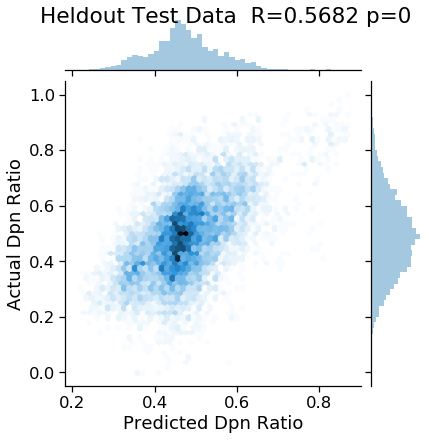

In [85]:
pred = res.predict(test_exog)
plot_scatter(pred,test_endog,kind='hex',xlabel='Predicted Dpn Ratio',
             ylabel='Actual Dpn Ratio',title='Heldout Test Data ')

In [86]:
exog.shape

(40272, 324)

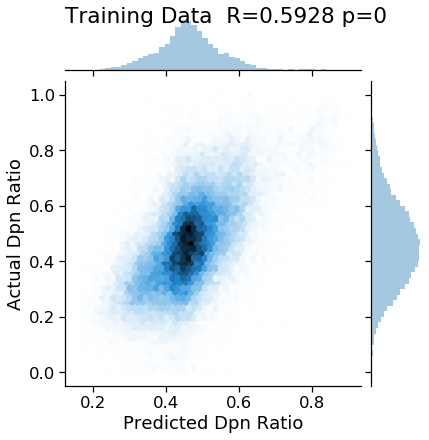

In [87]:
pred = res.predict(exog)
plot_scatter(pred,endog,kind='hex',xlabel='Predicted Dpn Ratio',
             ylabel='Actual Dpn Ratio',title='Training Data ')

In [88]:
conditions2clean = {'es':'ESC','ed':'DE',
                    'brachyury':'ESC Brachyury+',
                    'foxa2':'ESC FoxA2+'}
condition_names = [conditions2clean[c] for c in conditions]

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


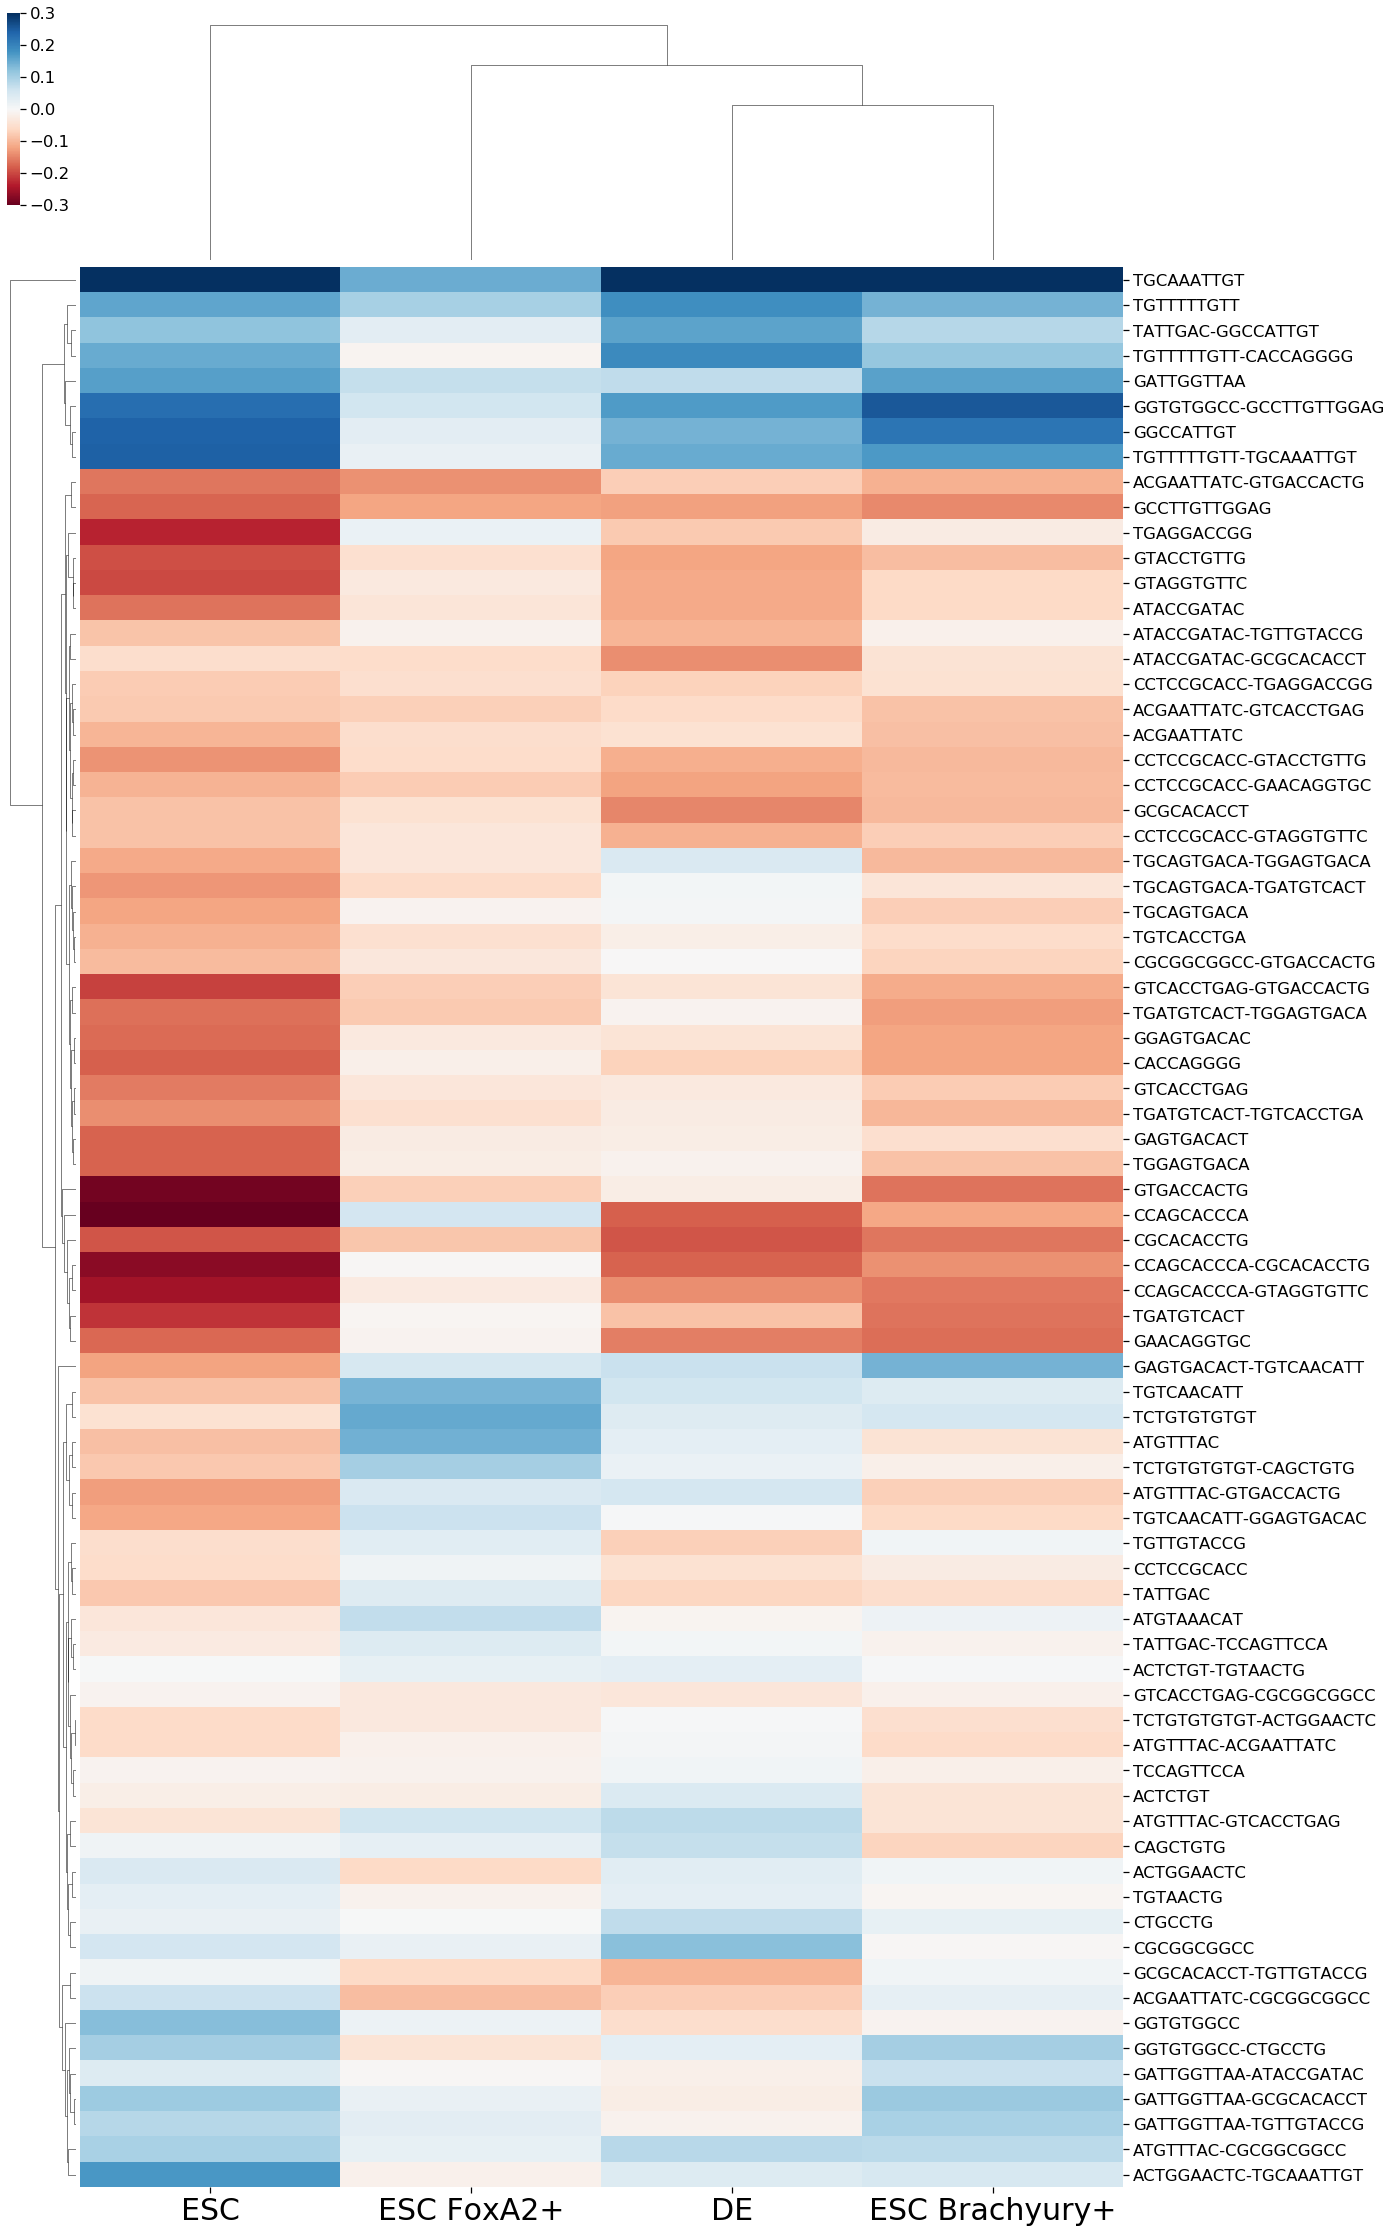

In [95]:
param_values = res.params
param_kmers_values = param_values[len(replicates):]
cmap = {'es':'blue','brachyury':'purple','foxa2':'aqua','ed':'red'}
big_mat = np.zeros((len(kmers),len(conditions)))

for j,condition in enumerate(conditions):
    big_mat[:,j] = param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]
big_df = pd.DataFrame(data=big_mat,columns=condition_names,index=kmers)
g = sns.clustermap(big_df,cmap='RdBu',figsize=(20,40),vmin=-0.3, vmax=0.3)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 30)
plt.tight_layout()
plt.savefig('plots/overexpression-experimental-results.svg',bbox_inches='tight')

In [91]:
condition_order=['ESC','ESC FoxA2+','ESC Brachyury+','DE']

GAGTGACACT-TGTCAACATT
ATGTTTAC-GTGACCACTG
TGCAGTGACA-TGGAGTGACA
TGTCAACATT
TGCAGTGACA-TGATGTCACT
TGCAGTGACA
ATGTTTAC
ATGTTTAC-GTCACCTGAG
TGTCAACATT-GGAGTGACAC
TCTGTGTGTGT-CAGCTGTG


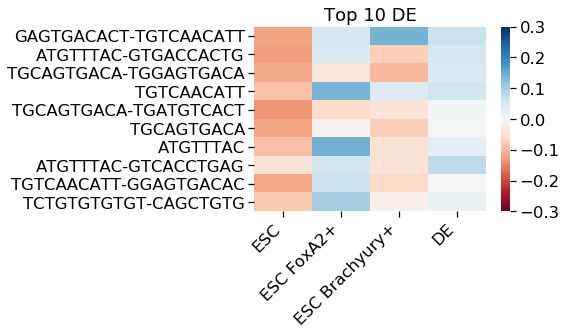

GGTGTGGCC
ACGAATTATC-CGCGGCGGCC
ACTGGAACTC-TGCAAATTGT
GATTGGTTAA-GCGCACACCT
GCGCACACCT-TGTTGTACCG
GGCCATTGT
GATTGGTTAA-TGTTGTACCG
TGTTTTTGTT-TGCAAATTGT
GATTGGTTAA
GGTGTGGCC-CTGCCTG


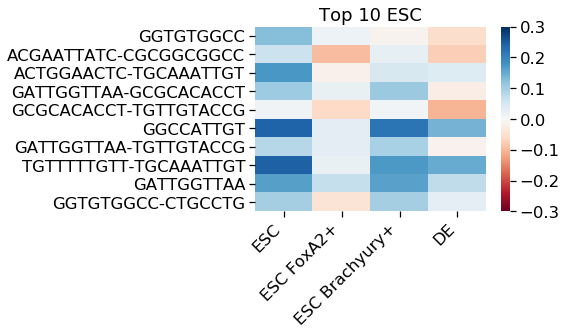

CCAGCACCCA
TGAGGACCGG
ATGTTTAC
TGTCAACATT
TCTGTGTGTGT
TCTGTGTGTGT-CAGCTGTG
TGTCAACATT-GGAGTGACAC
ATGTTTAC-GTGACCACTG
GAGTGACACT-TGTCAACATT
TATTGAC


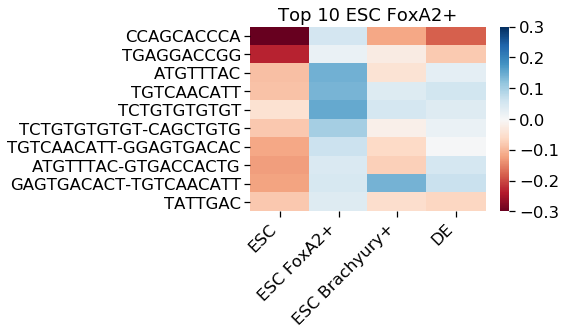

GAGTGACACT-TGTCAACATT
TGTCAACATT
TCTGTGTGTGT
TGTTGTACCG
ATGTAAACAT
GGTGTGGCC-GCCTTGTTGGAG
GATTGGTTAA-ATACCGATAC
GATTGGTTAA-TGTTGTACCG
ACTCTGT-TGTAACTG
CTGCCTG


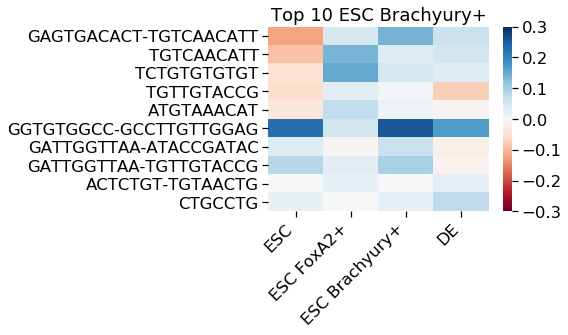

In [96]:
es_ind = conditions.index('es')
ed_ind = conditions.index('ed')
for j,condition in enumerate(conditions):
    if condition != 'es':
        allsorted = np.argsort((param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]-param_kmers_values[es_ind*len(kmers):(es_ind*len(kmers)+len(kmers))]))[::-1]
    else:
        allsorted = np.argsort((param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]-param_kmers_values[ed_ind*len(kmers):(ed_ind*len(kmers)+len(kmers))]))[::-1]

    top = allsorted[param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))][allsorted]>0][:10]
    for t in top:
        print(kmers[t])
    data = np.zeros((len(top),len(conditions)))
    for oj,oth in enumerate(conditions):
        for ti,t in enumerate(top):
            data[ti,oj] = param_kmers_values[oj*len(kmers)+t]
    data_df = pd.DataFrame(data=data,
                           columns=condition_names,
                           index=[kmers[t] for t in top])
    data_df = data_df[condition_order]
    plt.figure(figsize=(8,5))
    sns.heatmap(data_df,cmap='RdBu',vmin=-0.3, vmax=0.3)
    plt.xticks(rotation=45,ha='right')
    plt.title('Top 10 '+conditions2clean[condition])
    plt.tight_layout()
    plt.savefig('plots/differential_kmers_heatmap_'+condition+'.svg',bbox_inches='tight')
    plt.show()